### 레이블 부족문제 다루기
| **특징**            | **Zero-shot**                              | **Few-shot**                              |
|:----------------------:|:--------------------------------------------:|:-------------------------------------------:|
| **레이블 수**       | 없음                                       | 매우 적음                                |
| **모델 접근 방식**  | 사전 학습된 모델의 일반화 능력 활용         | 제한된 데이터로 추가 학습 또는 조정       |
| **사용 사례**       | 완전히 새로운 태스크                        | 유사한 태스크지만 데이터가 적음          |

- 레이블 데이터 ⬇️, 레이블 안된 데이터 ⬆️ 일때
    - UDA(Unsupervised Data Augmentation) : 데이터 증강
    - UST(Uncertainty-aware Self-training) : 불확실성(softmax 또는 베이지안 분포로 파악)이 낮은 모델만 추출

### 데이터 셋 불러오고 전처리 하기

In [1]:
import pandas as pd

df = pd.read_json('dataset/github-issues-transformers.jsonl', lines=True)

print("df 크기 : ",df.shape)
print("df cols : ", [col for col in df.columns])
display("df labels : ",df.labels[2])

df 크기 :  (9930, 26)
df cols :  ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'body', 'performed_via_github_app', 'pull_request']


'df labels : '

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

In [2]:
cols = ["url", "id", "title" , "user" , "labels", "state" , "created_at", "body"]

df = df[cols]

In [3]:
# 필요한 밸류만 추출
df["labels"] = df["labels"].map(lambda x: [i["name"] for i in x])

In [4]:
# 각 글에 대하여 라벨 갯수
df["labels"].apply(lambda x: len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [5]:
# 각 라벨 별 개수 확인
df["labels"].explode().value_counts().to_frame().head(8).T

labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


In [6]:
# 필용한 라벨만
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

In [7]:
df["labels"] = df["labels"].apply(lambda x : [label for label in x
                                              if label in label_map.keys()])

In [8]:
df["split"] = "unlabeled"
mask_over_zero = df["labels"].apply(lambda x:len(x)) > 0
# df.iloc[mask_over_zero, "split"] = "labeled"
df.loc[mask_over_zero, "split"] = "labeled"

In [9]:
df["labels"] = df["labels"].apply(lambda x: [label_map[i] for i in x
                                             if i in label_map.keys()] or x)

In [10]:
df['labels'].explode().value_counts().to_frame().T[label_map.values()]

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,examples,documentation
count,106,98,64,46,42,41,37,24,28


In [11]:
# check one sample
for col in ["title", "body", "labels"]:
    print(f"{col}:{df.iloc[26][col]}")
    print("-*-" * 50)

title:Add new CANINE model
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
body:# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy

In [12]:
df['text']= df.apply(lambda x : x['title'] + "\n\n" + x['body'] ,axis=1)

In [13]:
df.drop_duplicates(subset=['text'],inplace=True) # 중복 제거
len(df)

9743

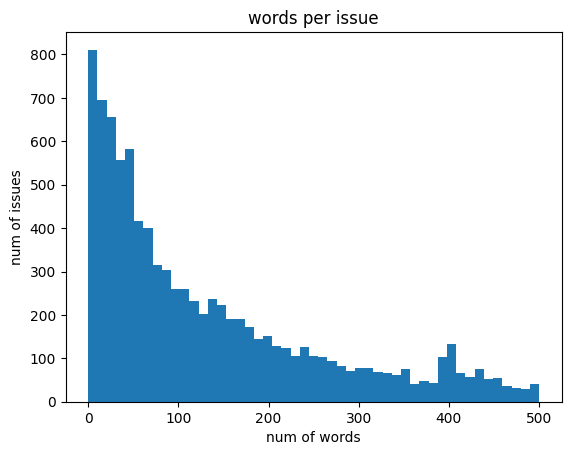

In [14]:
import numpy as np
import matplotlib.pyplot as plt

df["text"].str.split().apply(len).hist(bins=np.linspace(0,500,50), grid=False)
plt.title("words per issue")
plt.xlabel("num of words")
plt.ylabel("num of issues")
plt.show()

### 훈련 세트로 만들기

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(df["labels"])

mlb. transform([["tokenization", "new model"], ["pytorch"]]) # 라벨의 이진화

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [16]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split

def balanced_train_test_split(df, test_size=0.5):
    idx = np.expand_dims(np.arange(len(df)), axis=1)
    lbl = mlb.transform(df["labels"])
    idx_train, _, idx_test, _ = iterative_train_test_split(idx, lbl, test_size=test_size)
    
    return df.iloc[idx_train[:,0]], df.iloc[idx_test[:,0]]

df_clean = df[["text", "labels", "split"]].reset_index(drop=True).copy()

In [17]:
np.random.seed(42)
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]] # 라벨이 없는 데이터 unsupervised
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]] # 라벨이 있는 데이터 supervised

# train, valid, test split in 라벨이 있는 데이터
df_train, df_tmp = balanced_train_test_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_train_test_split(df_tmp, test_size=0.5)

In [18]:
# set as a dataset
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsupervised": Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

/opt/anaconda3/envs/t/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 220
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 110
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 110
    })
    unsupervised: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

### 훈련 슬라이스
- 점진적으로 늘려가며 훈련 데이터셋이 늘어남

In [77]:
import numpy as np

np.random.seed(42)
all_indices = np.expand_dims(list(range(len(ds['train']))),axis=1)
indices_pool = all_indices.copy()
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

In [78]:
for i, k in enumerate(train_samples):
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [84]:
# 목표 분할 크기, # 실제 분할 크기
train_samples, [len(x) for x in train_slices]

([8, 16, 32, 64, 128, 220], [10, 19, 38, 70, 137, 220])

### 베이스 모델 설정(나이브 베이즈 분류기 : Naïve Bayes Classification)

1. 정규 표현식, 수동 규칙이 간단하고, 실제 문제를 잘 해결하기도함
2. 복잡한 모델을 구축하기전에 간단히 데이터의 가용성이 검증이 됨

- **micro** : 자주 등장하는 레이블의 성능 추적
- **macro** : 빈도를 부시하고 모든 레이블에 대한 성능 추적

In [92]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map: 100%|██████████| 9303/9303 [00:00<00:00, 288354.91 examples/s]


In [118]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [119]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    ds_train_inst = ds["train"].select(train_slice)
    y_train = np.array(ds_train_inst["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    # Bag of Words
    count_vect = CountVectorizer() # 단어의 빈도수를 이용한 벡터화

    X_train_count = count_vect.fit_transform(ds_train_inst["text"]) # using fit_transform
    X_test_count = count_vect.transform(ds["test"]["text"]) # using just transform

    clf = BinaryRelevance(classifier=MultinomialNB())
    clf.fit(X_train_count, y_train)

    y_pred = clf.predict(X_test_count)
    clf_report = classification_report(
        y_test, y_pred, target_names=mlb.classes_,zero_division=0 , output_dict=True)
    
    macro_scores["navie_bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["navie_bayes"].append(clf_report["micro avg"]["f1-score"])

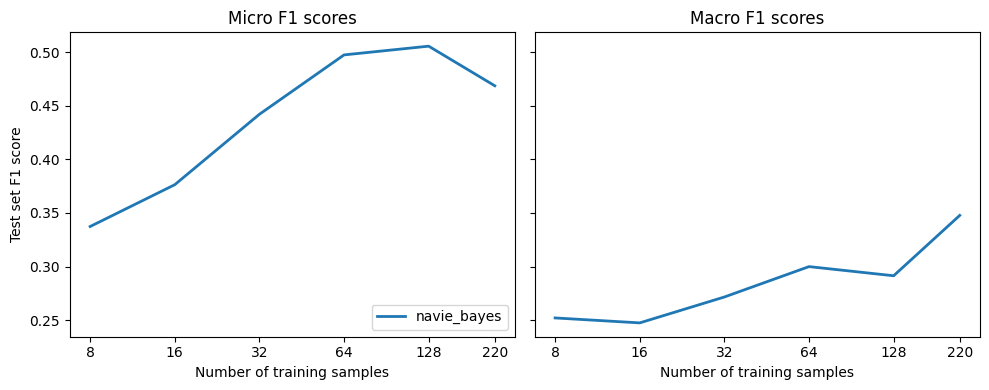

In [146]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")
    
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

plot_metrics(micro_scores, macro_scores, train_samples, "navie_bayes")

### 제로 샷 분류

- 마스킹된 토큰을 가리고 예측하는 모델
    - my [MASK] movie is MIB.

In [160]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")
pipe("my [MASK] movie is MIB.")[0]["sequence"]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


'my favorite movie is mib.'

In [180]:
for i in pipe("my [MASK] movie is MIB."):
    print(f'{i["token_str"]:12s}: {i["score"]:0.2f}')

favorite    : 0.93
favourite   : 0.04
next        : 0.01
first       : 0.00
new         : 0.00


- target setting

In [213]:
disc = "there are so many things that i like, "
prompt = "[MASK] is my favorate."

out = pipe(disc + prompt, targets=["animal", "car", "that", "this"])
for i in out:
    print(f"{i['token_str']}: {i['score']:0.6f}")

this: 0.175305
that: 0.154841
animal: 0.000023
car: 0.000007


- text entailment : 두개의 텍스트 구절이 연결되는지 파악(모순성 파악)
    - label : premise, hypothsis => entailment, neutral, contradiction. 셋 중 하나의 레이블을 가진다.

In [226]:
# 제로샷 분류
pipe = pipeline("zero-shot-classification", device=0)

sample = ds["train"][0]

out = pipe(sample["text"], list(label_map.values()), multi_label = True)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [249]:
for l,s in zip(out["labels"],out["scores"]):
    print(f"label: {l:20s}, score: {s:0.2f}")

label: new model           , score: 1.00
label: model training      , score: 0.75
label: documentation       , score: 0.59
label: pipeline            , score: 0.49
label: tensorflow or tf    , score: 0.36
label: usage               , score: 0.31
label: examples            , score: 0.29
label: pytorch             , score: 0.28
label: tokenization        , score: 0.22


In [251]:
def zero_shot_pipe(example):
    out = pipe(example["text"], list(label_map.values()),multi_label=True)
    example["predicted_labels"] = out["labels"]
    example["scores"] = out["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipe)

Map:  25%|██▌       | 28/110 [01:59<05:50,  4.27s/ examples]


KeyboardInterrupt: 

In [ ]:
def get_pred(example, threshold=None, top_k=None):
    pred = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score > threshold:
                pred.append(label)
    elif top_k:
        pred = example["predicted_labels"][:top_k]
    else:
        raise ValueError("threshold or top_k should be provided")
    return {"pred_label_ids" : list(np.squeeze(mlb.transform([pred])))}